In [1]:
%reset -f
from helpers import load_all_data, vectorized_flatten, sigmoid, get_log_loss, get_accuracy, sigmoid_derivative, gradient_update, get_loss_plot, plot_loss
import numpy as np
import cv2

In [2]:
X_train, y_train, X_dev, y_dev, X_test, y_test = load_all_data("../setup/data")

In [3]:
h1 = 8
h2 = 4
lr = 0.1

# 3.3.4

In [4]:
def initialize(X): 

    
    dim1 = 1/np.sqrt(X.shape[0])
    W1 = dim1 * np.random.randn(h1, 28**2)
    
    dim2 = 1/np.sqrt(W1.shape[1])
    W2 = dim2 * np.random.randn(h2, h1)
    
    dim3 = 1/np.sqrt(W2.shape[1])
    W3 = dim3 * np.random.randn(1, h2)

    b1 = np.zeros((h1, 1))
    b2 = np.zeros((h2, 1))
    b3 = np.zeros((1, 1))
    
    weights = (W1, W2, W3)
    biases = (b1, b2, b3)
    
    return weights, biases

In [5]:
def forward_pass(X, weights, biases):

    W1, W2, W3 = weights
    b1, b2, b3 = biases
    
    z1 = W1 @ X + b1
    a1 = sigmoid(z1)
    
    z2 = W2 @ z1 + b2
    a2 = sigmoid(z2)
    
    z3 = W3 @ z2 + b3
    a3 = sigmoid(z3)
    
    activations = (z1, a1, z2, a2, z3, a3)
    
    return activations

In [6]:
def backpropagation(X, y, weights, biases, activations):
    
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    z1, a1, z2, a2, z3, a3 = activations
    m = max(y.shape)
    #print(m)
    
    dz3 = (a3 - y)/m
    #print("dz3", dz3.shape)
    
    dW3 = np.dot(dz3, a2.T)
    #print("dW3", dW3.shape)
    
    db3 = np.sum(dz3, axis=1).reshape(-1, 1)
    #print("db3", db3.shape)
    
    da2 = np.dot(W3.T, dz3)
    #print("da2", da2.shape)
    
    dz2 = da2 * sigmoid_derivative(z2)
    #print("dz2", dz2.shape)
    
    dW2 = np.dot(dz2, a1.T)
    #print("dW2", dW2.shape)
    
    db2 = np.sum(dz2, axis=1).reshape(-1, 1)
    #print("db2", db2.shape)
    
    da1 = np.dot(W2.T, dz2)
    #print("da1", da1.shape)
    
    dz1 = da1 * sigmoid_derivative(z1)
    #print("dz1", dz1.shape)
    
    dW1 = np.dot(dz1, X.T)
    #print("dW1", dW1.shape)
    
    db1 = np.sum(dz1, axis=1).reshape(-1, 1)
    #print("db1", db1.shape)
    
    return db1, dW1, db2, dW2, db3, dW3

In [7]:
def update_parameters(weights, biases, gradients, learning_rate):
    
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    
    db1, dW1, db2, dW2, db3, dW3 = gradients
    
    W1 = gradient_update(W1, learning_rate, dW1)
    W2 = gradient_update(W2, learning_rate, dW2)
    W3 = gradient_update(W3, learning_rate, dW3)
   
    b1 = gradient_update(b1, learning_rate, db1)
    b2 = gradient_update(b2, learning_rate, db2)
    b3 = gradient_update(b3, learning_rate, db3)
    
    weights = (W1, W2, W3)
    biases = (b1, b2, b3)
    
    return weights, biases

# Finite Differences

In [8]:
X_train_flattened = vectorized_flatten(X_train)
X_dev_flattened = vectorized_flatten(X_dev)
X_test_flattened = vectorized_flatten(X_test)

y_train = y_train.reshape(1, -1)
y_dev = y_dev.reshape(1, -1)
y_test = y_test.reshape(1, -1)

weights, biases = initialize(X_train_flattened)

In [9]:
def log_loss(y, y_pred):
    m = max(y.shape)
    return -1/m * np.sum(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

In [10]:
def finite_differences(example, truth, weights, biases, delta_h=1e-9):
    
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    
    I, J = W3.shape # Change here
    
    deltaW = np.zeros((I, J))
    
    activations = forward_pass(example, weights, biases)
    db1, dW1, db2, dW2, db3, dW3 = backpropagation(example, truth, weights, biases, activations)
    
    for i in range(I):
        for j in range(J):
    
            W_plus = np.copy(W3) # Change here
            W_minus = np.copy(W3) # Change here
            
            W_plus[i][j] += delta_h
            W_minus[i][j] -= delta_h
            
            weights_plus = [W1, W2, W_plus] # Change here
            weights_minus = [W1, W2, W_minus] # Change here
            
            activations_plus = forward_pass(example, weights_plus, biases)
            activations_minus = forward_pass(example, weights_minus, biases)

            loss_plus = get_log_loss(truth, activations_plus[-1])
            loss_minus =  get_log_loss(truth, activations_minus[-1])

            deltaW[i][j] = (loss_plus - loss_minus)/(2 * delta_h)

    difference = np.linalg.norm(dW3 - deltaW) # Change here
    
    return dW3, deltaW, difference, activations_plus[-1], activations_minus[-1] # Change here

In [11]:
idx = 10
dW, deltaW, difference, activations_plus, activations_minus = finite_differences(X_train_flattened[:, idx].reshape(-1, 1), 
                                            y_train[:, idx].reshape(-1, 1), weights, biases)

print("dW", dW)
print("deltaW", deltaW)
print("difference", difference)
print(activations_plus, activations_minus)

dW [[-0.27236277 -0.27032343 -0.25826335 -0.26647707]]
deltaW [[-0.06586059 -0.05767337 -0.00937245 -0.04225104]]
difference 0.4473110690196198
[[0.48815937]] [[0.48815937]]


# 3.3.5

In [12]:
X_train_flattened = vectorized_flatten(X_train)
X_dev_flattened = vectorized_flatten(X_dev)
X_test_flattened = vectorized_flatten(X_test)

y_train = y_train.reshape(1, -1)
y_dev = y_dev.reshape(1, -1)
y_test = y_test.reshape(1, -1)

weights, biases = initialize(X_train_flattened)
epochs = 2000

history = {
    "weights": [weights],
    "losses": [], 
    "biases": [biases],
    "accuracies": []
}

for epoch in range(epochs):
    weights = history['weights'][epoch]
    biases = history['biases'][epoch]
    
    activations = forward_pass(X_train_flattened, weights, biases)
    gradients = backpropagation(X_train_flattened, y_train, weights, biases, activations)
    
    weights, biases = update_parameters(weights, biases, gradients, lr)
    
    y_prob = activations[-1]
    y_pred = np.where(y_prob > 0.5, 1, 0)
    
    loss = get_log_loss(y_train, y_prob)
    accuracy = get_accuracy(y_train, y_pred)
    
    history["weights"].append(weights)
    history["losses"].append(loss)
    history["biases"].append(biases)
    history["accuracies"].append(accuracy)

    if np.isnan(loss):
        break
    
    print(loss)

8267.376825575564
8265.656243319028
8263.932831562513
8262.206371853405
8260.476646325049
8258.74343763963
8257.006528934595
8255.265703772358
8253.520746093047
8251.771440170027
8250.017570567987
8248.258922103392
8246.49527980709
8244.726428888916
8242.952154704128
8241.172242721508
8239.38647849301
8237.594647624786
8235.796535749543
8233.991928500025
8232.180611483607
8230.362370257833
8228.536990306882
8226.704257018806
8224.863955663528
8223.0158713715
8221.159789112968
8219.295493677775
8217.42276965567
8215.541401417051
8213.651173094111
8211.75186856234
8209.843271422347
8207.925164981967
8205.997332238618
8204.059555861884
8202.111618176295
8200.153301144277
8198.184386349245
8196.20465497884
8194.213887808257
8192.21186518369
8190.198367005824
8188.173172713427
8186.136061266954
8184.086811132219
8182.025200264083
8179.951006090161
8177.864005494544
8175.763974801515
8173.650689759272
8171.523925523624
8169.383456641683
8167.229057035531
8165.060499985855
8162.877558115559
8

4025.9148351416607
4013.965251440576
4002.0681199306864
3990.2232750776247
3978.4305508359303
3966.6897807694495
3955.0007981651306
3943.3634361404183
3931.7775277443757
3920.242906052725
3908.7594042569785
3897.3268557478077
3885.945094192844
3874.613953609065
3863.3332684299467
3852.1028735675413
3840.922604469662
3829.7922971723247
3818.711788347635
3807.6809153472595
3796.699516241679
3785.7674298553434
3774.884495797929
3764.0505544918333
3753.2654471960614
3742.5290160266677
3731.8411039739112
3721.201554916241
3710.6102136312975
3700.066925804045
3689.5715380321844
3679.123897828991
3668.723853623699
3658.3712547595715
3648.065951489781
3637.807794971238
3627.5966372564703
3617.4323312836823
3607.31473086512
3597.243690673832
3587.2190662289586
3577.2407138796434
3567.3084907876682
3557.4222549089245
3547.581864973804
3537.787180466612
3528.038061604085
3518.3343693131155
3508.6759652077467
3499.0627115655398
3489.494471303377
3479.971107952785
3470.4924856348416
3461.0584690347

1900.4838837659381
1899.2403525315924
1898.002375017387
1896.7699185579077
1895.5429507024182
1894.3214392133948
1893.105352065072
1891.894657442
1890.6893237376096
1889.4893195527843
1888.2946136944436
1887.105175174134
1885.9209732066297
1884.7419772085395
1883.5681567969298
1882.3994817879445
1881.2359221954443
1880.077448229651
1878.9240302957978
1877.7756389927936
1876.6322451118904
1875.4938196353614
1874.3603337351924
1873.231758771772
1872.1080662925995
1870.989228030995
1869.8752159048217
1868.7660020152143
1867.6615586453179
1866.561858259031
1865.466873499764
1864.3765771891967
1863.2909423260544
1862.2099420848792
1861.133549814824
1860.0617390384452
1858.9944834505018
1857.931756916771
1856.8735334728651
1855.819787323058
1854.770492839122
1853.7256245591664
1852.6851571864904
1851.6490655884418
1850.6173247952806
1849.5899099990538
1848.5667965524756
1847.5479599678179
1846.533375915803
1845.5230202245123
1844.5168688782924
1843.514898016678
1842.5170839333134
1841.523403

1628.8631601775573
1628.5599050003816
1628.2572769980895
1627.9552736902288
1627.6538926086141
1627.3531312972589
1627.052987312319
1626.7534582220032
1626.4545416065257
1626.1562350580248
1625.8585361804985
1625.5614425897577
1625.2649519133201
1624.9690617903861
1624.6737698717432
1624.3790738197226
1624.0849713081157
1623.7914600221266
1623.498537658296
1623.2062019244456
1622.9144505396139
1622.623281233996
1622.3326917488694
1622.0426798365436
1621.7532432602993
1621.4643797943227
1621.1760872236482
1620.8883633440894
1620.6012059621953
1620.3146128951748
1620.0285819708547
1619.7431110275938
1619.4581979142624
1619.1738404901434
1618.8900366249136
1618.60678419855
1618.324081101307
1618.0419252336283
1617.7603145061146
1617.4792468394544
1617.1987201643826
1616.9187324216018
1616.6392815617444
1616.3603655453253
1616.0819823426618
1615.8041299338493
1615.5268063086792
1615.2500094666111
1614.9737374167084
1614.6979881775824
1614.422759777338
1614.1480502535399
1613.8738576531441


1532.7854498530132
1532.6244555458295
1532.4636165781935
1532.3029325840753
1532.1424031988608
1531.9820280592764
1531.8218068033693
1531.661739070556
1531.5018245015744
1531.3420627384853
1531.182453424687
1531.02299620487
1530.8636907250634
1530.7045366325824
1530.545533576069
1530.3866812054214
1530.2279791718572
1530.0694271278603
1529.9110247272179
1529.7527716249347
1529.5946674773375
1529.4367119419958
1529.278904677741
1529.1212453446442
1528.963733603996
1528.8063691183916
1528.6491515516188
1528.492080568677
1528.3351558358534
1528.1783770205618
1528.0217437915353
1527.8652558186175
1527.7089127729096
1527.5527143267182
1527.3966601535103
1527.2407499279489
1527.0849833258867
1526.929360024356
1526.7738797015581
1526.6185420368734
1526.4633467108138
1526.3082934050685
1526.153381802484
1525.9986115870536
1525.843982443901
1525.689494059304
1525.5351461206587
1525.3809383164862
1525.226870336477
1525.072941871369
1524.9191526130685
1524.76550225456
1524.6119904899615
1524.4586

In [13]:
best_epoch = np.array(history["losses"][:-1]).argmin()
print(f"best accuracy: {history['accuracies'][best_epoch]}")
print(f"best loss: {history['losses'][best_epoch]}")
print(f"best epoch: {best_epoch}")

best accuracy: 0.9638333333333333
best loss: 1502.0540615743948
best epoch: 1998


# 3.3.6

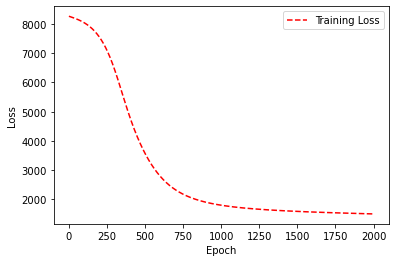

In [14]:
plot_loss("loss.png", history["losses"][:-2])

# 3.3.7

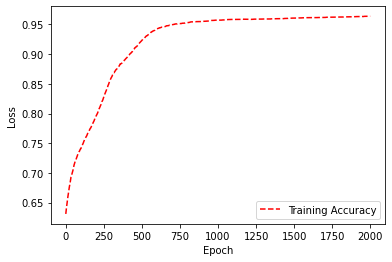

In [15]:
plot_loss("accuracy.png", history["accuracies"][:-2], label='Training Accuracy')

# 3.3.8

In [16]:
weights = history["weights"][best_epoch]
biases = history["biases"][best_epoch]
activations = forward_pass(X_dev_flattened, weights, biases)

y_dev_prob = activations[-1]
y_dev_pred = np.where(y_dev_prob > 0.5, 1, 0)

loss = get_log_loss(y_dev, y_dev_prob)
accuracy = get_accuracy(y_dev, y_dev_pred)
print(f"Dev set accuracy: {accuracy}")

Dev set accuracy: 0.968
